In [1]:
# MIT License
#
# @title Copyright (c) 2024 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the HDSI Winter Workshop on LLMs as Autonomous Agents


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II: Grounding Agents with Fine-tuning and RL**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 1 hour


## March 6, 2025  <br> Mauricio Tec



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning and reinforcement learning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


See also:

* [Previous (Part I): Introduction to Agentic Frameworks](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part1.ipynb)
* [Pre-assignment: Setup LLM Access & API Keys](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb)


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

As in part I, we will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft`, `bitsandbytes`, `accelerate`. For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning.
* Lastly, we will continue using the `smolagents` library for implementing the basic react loop functionality.

<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [3]:
%pip install -q \
  transformers[torch,accelerate] \
  bitsandbytes \
  trl[peft] \
  textworld-express

# If you receive a conflict with colab and jupyter with pandas or anyio, feel free to ignore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `meta-llama/Llama-3.2-1B-Instruct` model. Let us check access.

If your access is restricted, check out the [pre-assignment notebook](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb) for more details on setting up access to Llama 3.2 on HuggingFace.


In [4]:
import os
from google.colab import userdata
import transformers
import peft
import torch

# Change logging of transformer to avoid so many warnings
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# Retrieve open AI key from Colab secrets
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

model_id = "meta-llama/Llama-3.2-1B-Instruct"


# # Now setup parameter efficient fine tuning (peft).
# # This is needed since we can just update the hunders of millions of parameters
# # of an LLM. We need to only update a few. This technique is called PEFT.
# # More precisely, we use the technique called LORA (low-rank adaptation).
# peft_config = peft.LoraConfig(
#     task_type=peft.TaskType.CAUSAL_LM,
#     r=1,
#     lora_alpha=2,
#     target_modules="all-linear",
#     lora_dropout=0.05,
#     bias="none",
# )

# Load model quantized! This will make the model way faster.
# For example, there are only 256 numbers in 8 bits! NN weights are projected/quantized/
# 8-bit models take only 1/4 of the memory.

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    # quantization_config=transformers.BitsAndBytesConfig(load_in_8bit=True),
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=True,
)
# model = peft.get_peft_model(model, peft_config)
# model.print_trainable_parameters()

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in LLM: {num_params:,}")

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# compute bytes in memory of model
obj_mem  = model.get_memory_footprint()
obj_mem_gb = obj_mem / (1024**3)
print(f"Memory footprint of model: {obj_mem_gb:.2f} gigabytes")


# Utility to generate text
def call_model(prompt, **kwargs):
    """Simple function to call the model."""

    pipe = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        **kwargs,
    )
    messages= [{"role": "user", "content": prompt}]
    result = pipe([{"role": "user", "content": prompt}])
    return result[0]['generated_text'][-1]['content']

call_model("What is the capital of France?")

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Number of parameters in LLM: 1,235,814,400


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Memory footprint of model: 2.30 gigabytes


'The capital of France is Paris.'

## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [30]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 20
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'put clean plate in shelf', 'close door to east', 'move east', 'open door to east', 'put clean plate in folding chair', 'inventory']

`<Action>` take clean plate

`<Obs>` You take the clean plate.

`<Reward>` 0.12

**Step 3**

`<Valid Actions>` ['inventory', 'take clean plate', 'move east', 'open door to east', 'look around', 'close door to east']

`<Action>` put clean plate in folding chair

`<Obs>` You put the clean plate in the folding chair.

`<Reward>` -0.12

**Step 4**

`<Valid Actions>` ['take clean plate', 'open door to east', 'move east', 'inventory', 'close door to east', 'look around']

`<Action>` close door to east

`<Obs>` That is already closed. 

`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['look around', 'inventory', 'take clean plate', 'close door to east', 'move east', 'open door to east']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'look around', 'close door to east', 'inventory', 'move east', 'take clean plate']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['open dishwasher', 'inventory', 'open door to west', 'move east', 'look around', 'take potato peeler', 'close door to west', 'open kitchen cupboard', 'open fridge', 'open cutlery drawer', 'move west', 'open trash can']

`<Action>` move east

`<Obs>` You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a potato peeler. 
To the East you see the living room. Through an open plain door, to the West you see the pantry. 

`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['close door to west', 'open dishwasher', 'inventory', 'open kitchen cupboard', 'close trash can', 'look around', 'open fridge', 'move west', 'take potato peeler', 'move east', 'open cutlery drawer', 'open door to west']

`<Action>` open trash can

`<Obs>` You open the trash can. It's empty inside.

`<Reward>` 0.00

**Step 9**

`<Valid Actions>` ['inventory', 'take potato peeler', 'open door to west', 'open cutlery drawer', 'move east', 'open dishwasher', 'open fridge', 'close door to west', 'close trash can', 'open kitchen cupboard', 'look around', 'move west']

`<Action>` open door to west

`<Obs>` That is already open. 

`<Reward>` 0.00

**Step 10**

`<Valid Actions>` ['take clean plate', 'inventory', 'close door to east', 'move east', 'open door to east', 'look around']

`<Action>` move west

`<Obs>` You are in the pantry. In one part of the room you see a folding chair that has a clean plate on it. There is also a shelf, that has nothing on it. 
Through an open plain door, to the East you see the kitchen. 

`<Reward>` 0.00

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate and refine a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [74]:
def build_task_prompt(memory, valid_actions):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + (
        f"\n\n`[Valid Actions]` {valid_actions}\n\n"
        "### Question\nYou must choose exactly one action from the valid actions list."
        " Which action should you take next?\n\n"
        "Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."
    )


def planning_step(task_prompt, previous_plan=None):
    """Generates an initial plan if none exists; otherwise, revises the given plan."""
    plan_prompt = task_prompt + (
        "\n\nOutline a plan to solve the task over the next few steps.\n\n"
        "Your answer should start 'My plan is' and contain single sentence as in the example. Answer with only one plan.\n"
        "Example plan: My plan is to explore the current room for misplaced objects, then locate their correct rooms.\n"
    )

    return call_model(plan_prompt)


def action_step(task_prompt, valid_actions, use_thoughts=False, example_thoughts=None):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if use_thoughts:
        thought_prompt = task_prompt + (
            "\n\nLet's think step by step before decided the next action."
            " What are your thoughts? Provide a short answer in 1-3 sentences"
        )
        if example_thoughts:
            thought_prompt += f"\n\n### Example\n\n{example_thoughts}\n\n"
        thoughts = call_model(thought_prompt)
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information."
    )
    response = call_model(task_prompt).strip("[]`:").strip()
    action = extract_valid_action(response, valid_actions)

    return {'action': action, 'thoughts': thoughts}


def extract_valid_action(response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"From the valid actions {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north.', extract only 'move north'.\n"
        "If the response is unclear, choose the most appropriate valid action.\n"
        "Example corrections:\n"
        "- 'You open the cabinet.' → 'open shoe cabinet'\n"
        "- 'Check my bag.' → 'inventory'\n"
        "- 'Move in the east direction.' → 'move east'\n"
        "Return only the corrected action without extra words."
    )
    corrected_action = call_model(correction_prompt).strip()
    return corrected_action if corrected_action in valid_actions else random.choice(valid_actions)

Let's now test these function in a single decision step.

In [75]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = ["## Welcome to TextWorld", f"`[Task]`: {env.getTaskDescription()}", f"`[Starting Obs]`: {obs}"]

# Initialize prompt
example_thoughts = """
I have a pair of socks. I must go to the dorm. I saw the dorm two steps ago. Two steps ago I was in a room north from here.
"""
task_prompt = build_task_prompt(memory, valid_actions)

# Start decision making
plan = planning_step(task_prompt)
memory.append(f"`[Initial Plan]` {plan}")

result = action_step(task_prompt, valid_actions, use_thoughts=True, example_thoughts=example_thoughts)
memory.append(f"`[Thoughts]` {result['thoughts']}")
memory.append(f"`[Action]` {result['action']}")

obs, reward, done, infos = env.step(result['action'])
updated_task_prompt = build_task_prompt(memory, valid_actions)
revised_plan = planning_step(task_prompt, plan)

memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")
memory.append(f"`[Revised Plan]` {revised_plan}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a yellow bell pepper. 
To the West you see a closed wood door. 

`[Initial Plan]` My plan is to pick up the wastepaper basket first.

*   Picking up the wastepaper basket will give you a clear view of the current room and allow you to identify the objects you need to find.
*   Once you've located the wastepaper basket, you can then move on to the other objects in the room to pick them up and place them in their usual locations.
*   This approach will allow you to efficiently gather all the objects you need to complete the task.

`[Thoughts]` To start, I should look around the living room before deciding on the next action.

`[Action]` open door to west

`[Obs]` You open the wood door, revealing the bathroom. 

`[Reward]` 0.00

`[Revised Plan]` My plan is to start by examining the objects in the living room and then move to the parts of the room that appear to be misplaced.

• Move to the part of the room that appears to be misplaced and examine the objects.
• Look for any objects that are out of place or do not have a clear owner.
• Check the book case, TV stand, arm chair, side table, coffee table, and end table for any objects that are missing.
• Move to the closed wood door and examine it for any objects that may have been left behind.
• If no objects are found, move to the sofa and examine the yellow bell pepper for any clues.
• If no objects are found, move to the wastepaper basket and examine it for any clues.

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [78]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    use_thoughts: bool = False,
    time_limit: int = 20,
    replan_every: int = 5,
    **kwargs
):
    # Initialize env
    env = env_factory(time_limit=time_limit, **kwargs)
    obs, infos = env.reset(gameFold="test")

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    task_prompt = build_task_prompt(memory, infos['validActions'])
    plan = planning_step(task_prompt)
    memory.append(f"`[Initial Plan]`: {plan}")

    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Start loop
    done = False
    total_reward = 0.0
    valid_actions = infos['validActions']

    step = 0
    while not done:
        memory.append(f"**Step {step + 1}**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")

        # Create the prompt
        task_prompt = build_task_prompt(memory, valid_actions)

        # Get new action from LLM
        actdict = action_step(
            task_prompt,
            valid_actions,
            use_thoughts,
            example_thoughts="I have a pair of socks. I must go to the dorm. I saw the dorm two steps ago. Two steps ago I was in a room north from here."
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(actdict['action'])

        # Update memory
        if use_thoughts:
            memory.append(f"`[Thoughts]`:\n\n{actdict['thoughts']}")
        memory.append(f"`[Action]`: {actdict['action']}")
        memory.append(f"`[Obs]`: {obs}")
        memory.append(f"`[Reward]`: {reward:0.2f}")

        # Replan if needed
        if (step + 1) % replan_every == 0:
            plan = planning_step(task_prompt, plan)
            memory.append(f"`[Revised Plan]`: {plan}")

        total_reward += reward
        step += 1
        pbar.update(1)

    return total_reward, memory


total_reward, memory = episode_rollout(
    gameFold="test", use_thoughts=True, time_limit=5, replan_every=3
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. In another part of the room you see a shampoo. 
To the North you see the bathroom. To the West you see a closed wood door. 

`[Initial Plan]`: My plan is to explore the current room for misplaced objects.

*   I will start by examining the objects in the room, including the dressing table, desk chair, desk, night stand, bed, and the chest of drawers.
*   I will also check the bathroom and the wood door to see if any objects have been misplaced.
*   If I find any misplaced objects, I will try to locate their correct rooms by searching for them in the other parts of the house.
*   Once I have located the misplaced objects, I will return to the room where they were originally placed and put them back in their correct locations.

**Step 1**

`[Time]` 14:46:59

`[Thoughts]`:

I should choose to "inventory" to see what objects are currently in the room before deciding where to go next. This will give me a better idea of what objects I need to find and where they might be misplaced.

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

**Step 2**

`[Time]` 14:47:00

`[Thoughts]`:

I should choose to "inventory" to see what objects are currently in the room before deciding where to go next.

### Action: inventory

### Obs: Inventory:
Your inventory is currently empty.

### Reward: 0.00

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

**Step 3**

`[Time]` 14:47:01

`[Thoughts]`:

Based on the situation, I think it would be best to "inventory" the current room to see what objects are currently in the room before deciding where to go next. This will give me a better idea of what objects I need to find and where they might be misplaced.

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

`[Revised Plan]`: My plan is to start by examining the objects in the room, including the dressing table, desk chair, desk, night stand, bed, and the chest of drawers. 

I will begin by examining the objects in the room.

**Step 4**

`[Time]` 14:47:04

`[Thoughts]`:

You should choose to "inventory" the current room to see what objects are currently in the room before deciding where to go next.

### Action: inventory

### Obs: Inventory:
Your inventory is currently empty.

### Reward: 0.00

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

**Step 5**

`[Time]` 14:47:05

`[Thoughts]`:

You should choose to "inventory" the current room to see what objects are currently in the room before deciding where to go next.

**Action: inventory**

**Obs:** Inventory: 
  Your inventory is currently empty.

**Reward:** 0.00

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

**Step 6**

`[Time]` 14:47:06

`[Thoughts]`:

Based on the situation, it would be best to "inventory" the current room to see what objects are currently in the room before deciding where to go next.

### Action: inventory

### Obs: Inventory:
Your inventory is currently empty.

### Reward: 0.00

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

`[Revised Plan]`: My plan is to start by examining the objects in the room, including the dressing table, desk chair, desk, night stand, bed, and the chest of drawers. 

I will begin by examining the objects in the room.

**Step 4**

`[Time]` 14:47:04

`[Thoughts]`:

You should choose to "inventory" the current room to see what objects are currently in the room before deciding where to go next.

### Action: inventory

### Obs: Inventory

`[Action]`: inventory

`[Obs]`: Inventory: 
  Your inventory is currently empty.


`[Reward]`: 0.00

`[Revised Plan]`: My plan is to start by examining the objects in the room, including the dressing table, desk chair, desk, night stand, bed, and the chest of drawers.

```python
# Step 1: inventory
inventory = []
objects = ["dressing table", "desk chair", "desk", "night stand", "bed", "chest of drawers", "shampoo"]
for obj in objects:
    inventory.append(obj)
    if obj == "shampoo":
        inventory.append("bathroom")
        break

# Step 2: Look around the room
for obj in inventory:
    if obj == "bathroom" or obj == "wood door":
        print(f"Object {obj} is not in the room.")

# Step 3: Move to the bathroom
bathroom = ["bathroom", "wood door"]
print(f"Moving to the bathroom: {bathroom}")
```

My plan is to move to the bathroom and check if any objects have been misplaced

### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [79]:
## uncomment to run

import json

episodes = {"no_thoughts": [], "thoughts": []}

num_episodes_per_agent = 20

for agent, results in episodes.items():
    printmd(f"### Agent {agent}")
    use_thoughts = (agent == "thoughts")

    for ep in range(num_episodes_per_agent):
        printmd(f"#### Episode {ep}")
        total_reward, memory = episode_rollout(gameFold="test", use_thoughts=use_thoughts)
        results.append({"ep": ep, "total_reward": total_reward, "memory": memory})

with open("results_baseline_agents.json", "w") as f:
    json.dump(episodes, f)

### Agent no_thoughts

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

### Agent thoughts

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

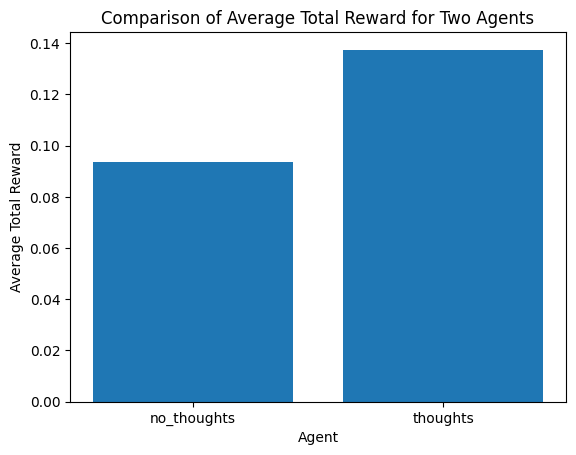

In [84]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("results_baseline_agents.json", "r") as f:
    episodes = json.load(f)

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in episodes[a]])
    for a in ["no_thoughts", "thoughts"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning Training with Low-rank Adaptation

# III. Reinforcement Learning

# Conclusion

### 🤗 What did we learn? 🤔

* 🪜 In an agentic framework, a problem is solved step by step.
* 🆘 LLMs are trained for text completion only. Hence, they struggle at simple operations such as counting or arithmetic which are not aligned with the next-token prediction training.
* 🙇‍♂️ They can immediately solve more complex task by *thinking step by step*. We can implement it with the chain-of-thought prompting technique.
* 🛠️ By leveraging their ability to call tools (code or JSON), we can fill the gap in their abilities. We can implement it with a simple react loop, which underlies most agentic frameworks.


### ➡️ Next steps ➡️

* 💾 More sophisticated memory: in the examples, we simply use the thought, observation, action history as the agent's memory. But for long sequences, we can use a RAG agent. Remember, each token costs money

* 👯 So far, we have approached the problem in a single-agent way. But many agentic frameworks allow to have multiple agents. A simple design is having an orchestrator agent which uses other agents as tools, but there are many use cases and designs.

* 🤖 In the next part of the tutorial, we will cover how to improve an agent performance with fine tuning and reinforcement learning.




<img src="https://drive.google.com/uc?export=view&id=1gA9lNXqJunfai38RS6DSRenuXKFysHW6" alt="drawing" width="400"/>
